# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The main finding is that the doubling time of cumulative confirmed cases for countries with many cases is generally on the order of 2 days, which agrees with [this preprint](https://www.medrxiv.org/content/10.1101/2020.02.05.20020750v3.full.pdf) analyzing the growth of cases in provinces in China.

The notebook is updated every evening Eastern Time.

## Important Caveats:
- This analysis uses data on the confirmed cases as reported by countries, which is different from the actual number of cases in each country (many of which are not tested). 
- Confirmed cases and actual cases in the population grow at different rates. E.g. if a country suddenly ramps up testing, the number of confirmed cases will rapidly rise, but the actual cases may not be rising as fast.
- Since we're using the entire timeline to infer the doubling times, **these values are not typically the current or most recent doubling times**. For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as Mainland China), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the initial exponential stage of the epidemic (i.e., in the past).

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [88]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [89]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/12/20


,3/12/20
Country/Region,
China,80932
Italy,12462
Iran,10075
"Korea, South",7869
France,2284
Spain,2277
Germany,2078
US,1663
Norway,702


## Curve Fitting Global COVID-19 Cases

In [90]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            #print('\tThe number of confirmed cases rose from',lastweek,'on',co.index[-8],'to',current,'on',co.index[-1])
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time:',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.98:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.98:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 80932
	Confirmed cases on 3/5/20 	 80537
	Ratio: 1.0
	Weekly increase: 0.5 %
	Daily increase: 0.1 % per day
	Doubling Time: 991.7 days

** Based on Logistic Fit**

	R^2: 0.994800814567
	Doubling Time:  3.23 (± 0.3 ) days


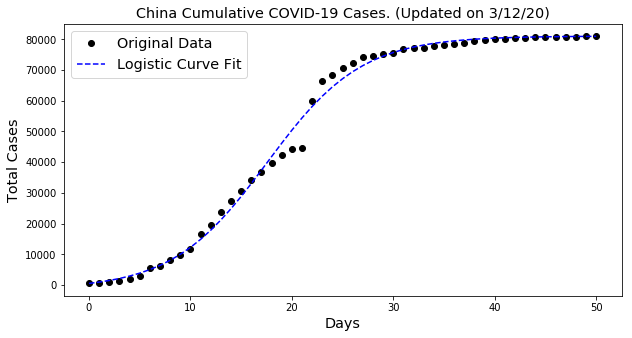



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 12462
	Confirmed cases on 3/5/20 	 3858
	Ratio: 3.23
	Weekly increase: 223.0 %
	Daily increase: 18.2 % per day
	Doubling Time: 4.1 days

** Based on Logistic Fit**

	R^2: 0.997218795939
	Doubling Time:  2.33 (± 0.21 ) days

** Based on Exponential Fit **

	R^2: 0.987808147884
	Doubling Time:  3.86 (± 0.29 ) days


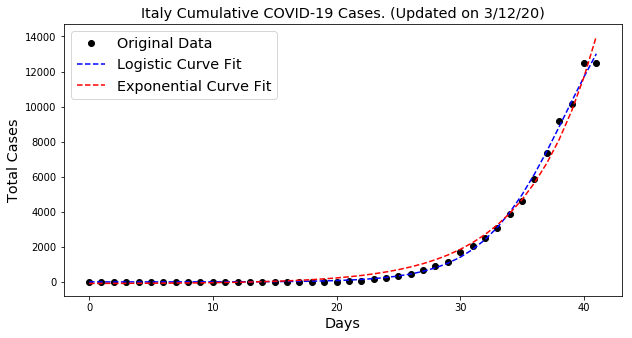



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 10075
	Confirmed cases on 3/5/20 	 3513
	Ratio: 2.87
	Weekly increase: 186.8 %
	Daily increase: 16.2 % per day
	Doubling Time: 4.6 days


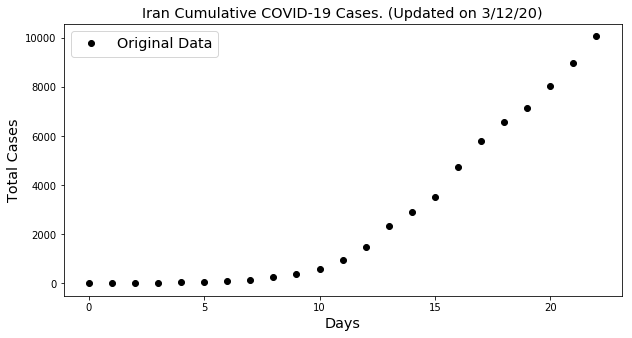



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 7869
	Confirmed cases on 3/5/20 	 6088
	Ratio: 1.29
	Weekly increase: 29.3 %
	Daily increase: 3.7 % per day
	Doubling Time: 18.9 days

** Based on Logistic Fit**

	R^2: 0.999583145139
	Doubling Time:  1.96 (± 0.05 ) days


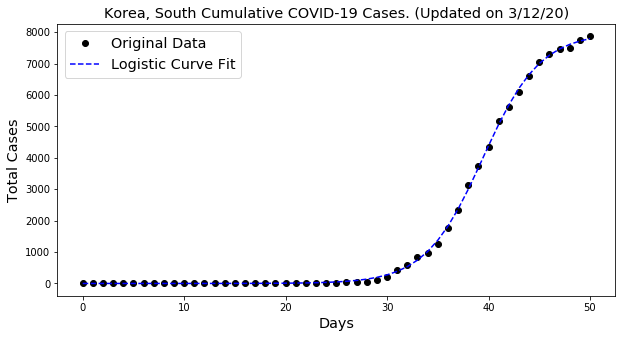



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 2284
	Confirmed cases on 3/5/20 	 380
	Ratio: 6.01
	Weekly increase: 501.1 %
	Daily increase: 29.2 % per day
	Doubling Time: 2.7 days

** Based on Exponential Fit **

	R^2: 0.981565502284
	Doubling Time:  3.03 (± 0.25 ) days


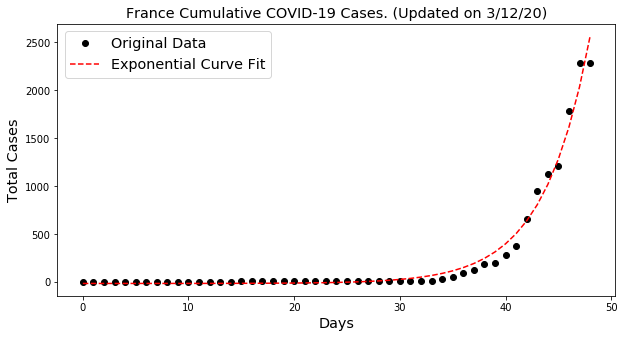



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 2277
	Confirmed cases on 3/5/20 	 259
	Ratio: 8.79
	Weekly increase: 779.2 %
	Daily increase: 36.4 % per day
	Doubling Time: 2.2 days


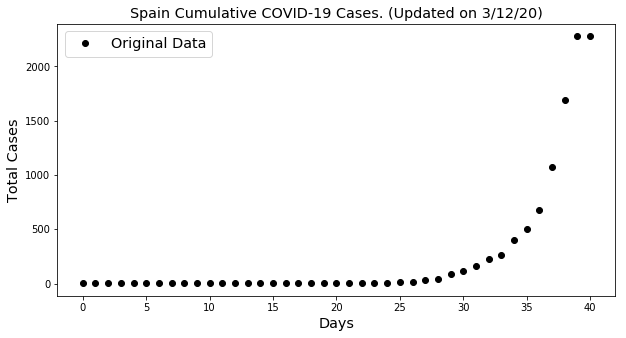



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 2078
	Confirmed cases on 3/5/20 	 482
	Ratio: 4.31
	Weekly increase: 331.1 %
	Daily increase: 23.2 % per day
	Doubling Time: 3.3 days

** Based on Exponential Fit **

	R^2: 0.989264345873
	Doubling Time:  3.14 (± 0.2 ) days


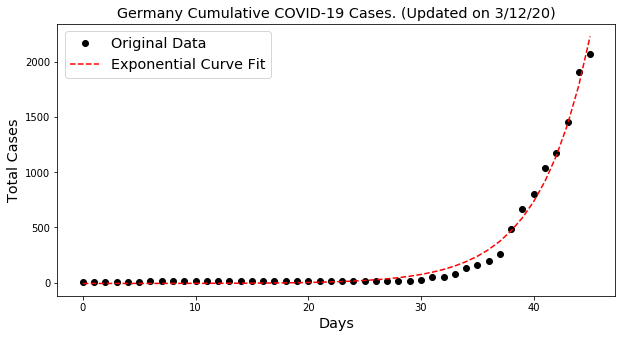



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 1663
	Confirmed cases on 3/5/20 	 217
	Ratio: 7.66
	Weekly increase: 666.4 %
	Daily increase: 33.8 % per day
	Doubling Time: 2.4 days

** Based on Exponential Fit **

	R^2: 0.996548270658
	Doubling Time:  2.28 (± 0.08 ) days


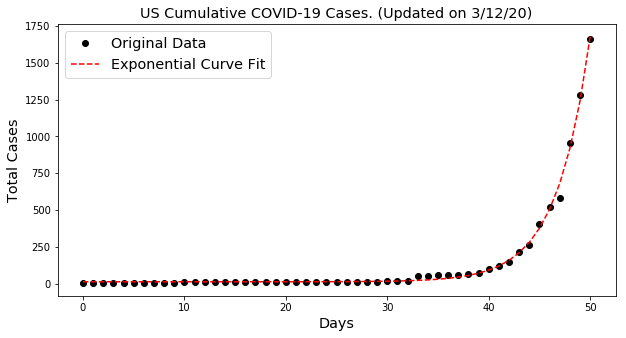



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 702
	Confirmed cases on 3/5/20 	 87
	Ratio: 8.07
	Weekly increase: 706.9 %
	Daily increase: 34.8 % per day
	Doubling Time: 2.3 days

** Based on Logistic Fit**

	R^2: 0.985338578551
	Doubling Time:  1.5 (± 0.67 ) days

** Based on Exponential Fit **

	R^2: 0.983578615463
	Doubling Time:  2.11 (± 0.35 ) days


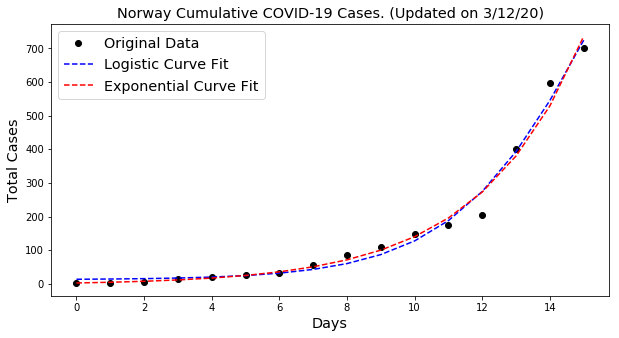



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.995459828088
	Doubling Time:  1.35 (± 0.15 ) days


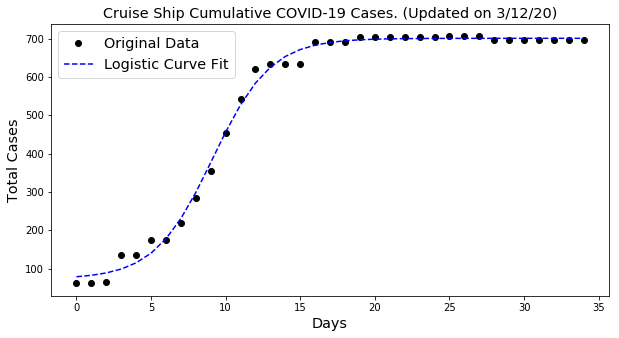



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 652
	Confirmed cases on 3/5/20 	 114
	Ratio: 5.72
	Weekly increase: 471.9 %
	Daily increase: 28.3 % per day
	Doubling Time: 2.8 days

** Based on Logistic Fit**

	R^2: 0.991045993884
	Doubling Time:  1.81 (± 0.56 ) days

** Based on Exponential Fit **

	R^2: 0.982183711038
	Doubling Time:  3.86 (± 0.85 ) days


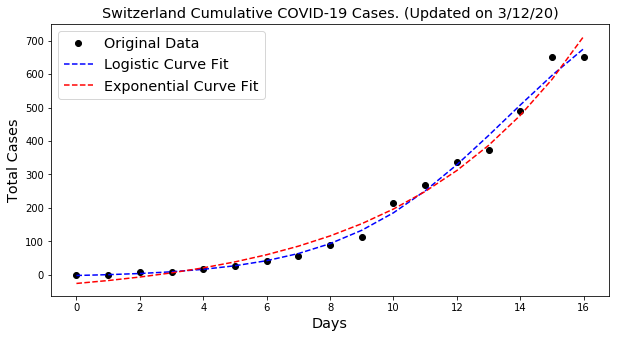



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 639
	Confirmed cases on 3/5/20 	 360
	Ratio: 1.78
	Weekly increase: 77.5 %
	Daily increase: 8.5 % per day
	Doubling Time: 8.5 days

** Based on Logistic Fit**

	R^2: 0.996195692496
	Doubling Time:  6.26 (± 0.79 ) days

** Based on Exponential Fit **

	R^2: 0.995034168845
	Doubling Time:  8.13 (± 0.41 ) days


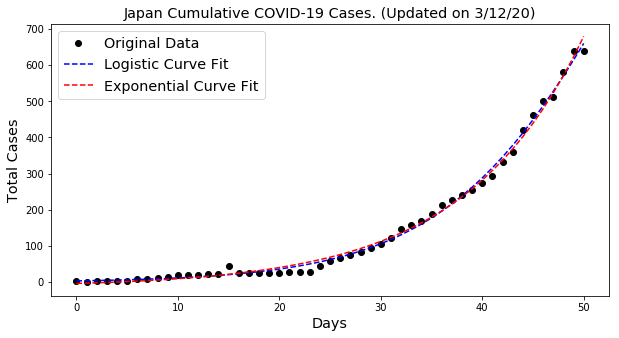



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 617
	Confirmed cases on 3/5/20 	 11
	Ratio: 56.09
	Weekly increase: 5509.1 %
	Daily increase: 77.8 % per day
	Doubling Time: 1.2 days

** Based on Exponential Fit **

	R^2: 0.980386970346
	Doubling Time:  1.37 (± 0.25 ) days


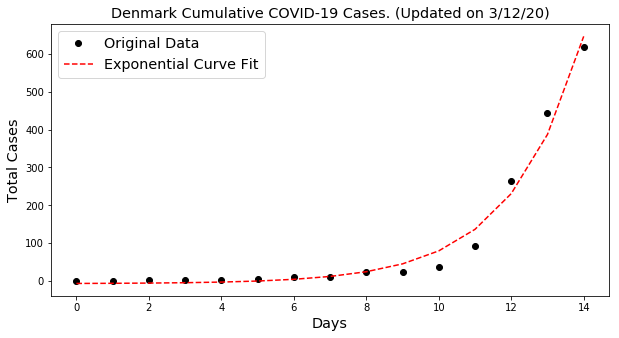



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 599
	Confirmed cases on 3/5/20 	 94
	Ratio: 6.37
	Weekly increase: 537.2 %
	Daily increase: 30.3 % per day
	Doubling Time: 2.6 days

** Based on Exponential Fit **

	R^2: 0.994245793858
	Doubling Time:  2.39 (± 0.12 ) days


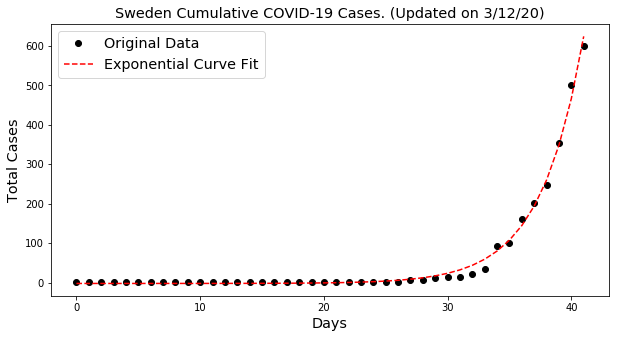



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 503
	Confirmed cases on 3/5/20 	 82
	Ratio: 6.13
	Weekly increase: 513.4 %
	Daily increase: 29.6 % per day
	Doubling Time: 2.7 days

** Based on Logistic Fit**

	R^2: 0.995012878182
	Doubling Time:  1.37 (± 0.3 ) days


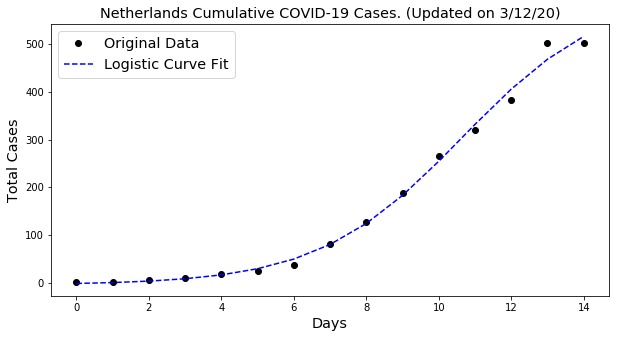



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 459
	Confirmed cases on 3/5/20 	 116
	Ratio: 3.96
	Weekly increase: 295.7 %
	Daily increase: 21.7 % per day
	Doubling Time: 3.5 days


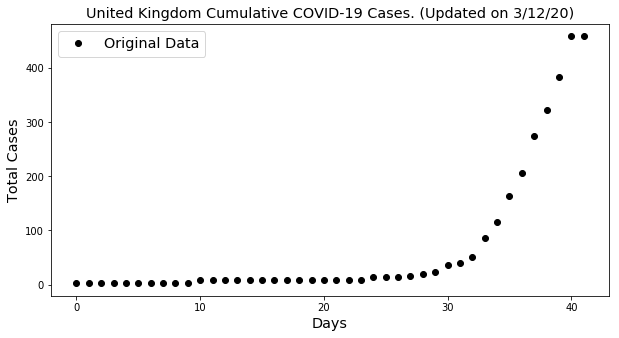



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 314
	Confirmed cases on 3/5/20 	 50
	Ratio: 6.28
	Weekly increase: 528.0 %
	Daily increase: 30.0 % per day
	Doubling Time: 2.6 days


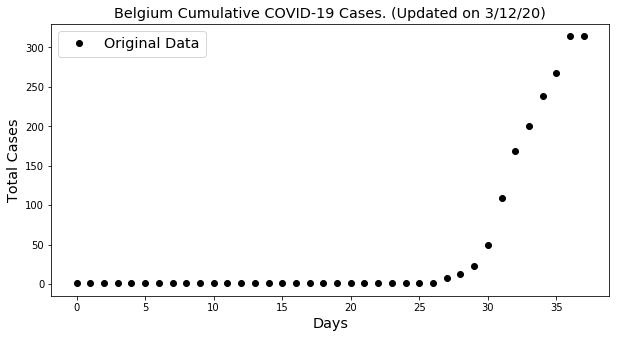



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 302
	Confirmed cases on 3/5/20 	 41
	Ratio: 7.37
	Weekly increase: 636.6 %
	Daily increase: 33.0 % per day
	Doubling Time: 2.4 days

** Based on Logistic Fit**

	R^2: 0.998862879486
	Doubling Time:  2.09 (± 0.29 ) days

** Based on Exponential Fit **

	R^2: 0.998153753682
	Doubling Time:  2.59 (± 0.15 ) days


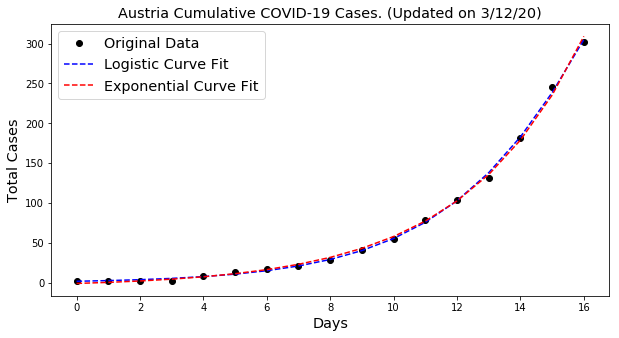



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 262
	Confirmed cases on 3/5/20 	 8
	Ratio: 32.75
	Weekly increase: 3175.0 %
	Daily increase: 64.6 % per day
	Doubling Time: 1.4 days


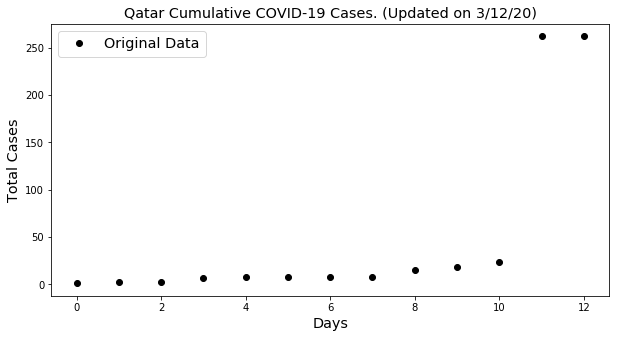



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 195
	Confirmed cases on 3/5/20 	 55
	Ratio: 3.55
	Weekly increase: 254.5 %
	Daily increase: 19.8 % per day
	Doubling Time: 3.8 days


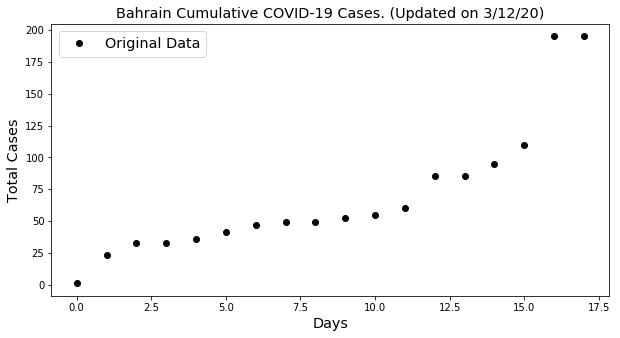



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 178
	Confirmed cases on 3/5/20 	 117
	Ratio: 1.52
	Weekly increase: 52.1 %
	Daily increase: 6.2 % per day
	Doubling Time: 11.6 days


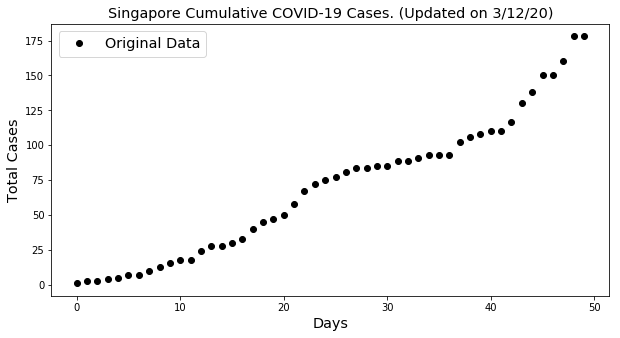



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 149
	Confirmed cases on 3/5/20 	 50
	Ratio: 2.98
	Weekly increase: 198.0 %
	Daily increase: 16.9 % per day
	Doubling Time: 4.4 days


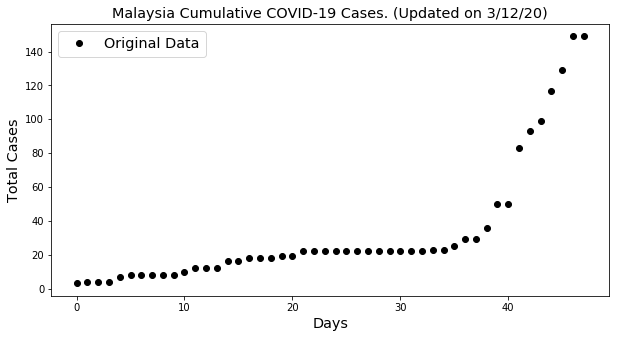



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 131
	Confirmed cases on 3/5/20 	 20
	Ratio: 6.55
	Weekly increase: 555.0 %
	Daily increase: 30.8 % per day
	Doubling Time: 2.6 days

** Based on Logistic Fit**

	R^2: 0.993499166
	Doubling Time:  2.46 (± 0.68 ) days

** Based on Exponential Fit **

	R^2: 0.992700371579
	Doubling Time:  3.05 (± 0.3 ) days


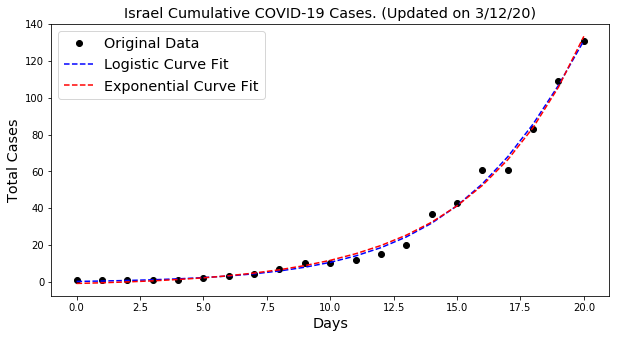



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 128
	Confirmed cases on 3/5/20 	 55
	Ratio: 2.33
	Weekly increase: 132.7 %
	Daily increase: 12.8 % per day
	Doubling Time: 5.7 days

** Based on Exponential Fit **

	R^2: 0.984000492771
	Doubling Time:  4.31 (± 0.35 ) days


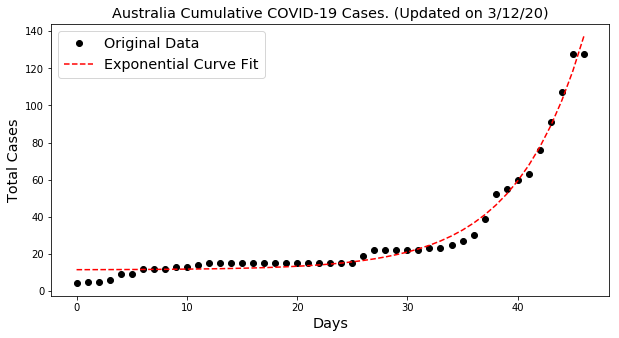



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 117
	Confirmed cases on 3/5/20 	 37
	Ratio: 3.16
	Weekly increase: 216.2 %
	Daily increase: 17.9 % per day
	Doubling Time: 4.2 days

** Based on Exponential Fit **

	R^2: 0.993068272164
	Doubling Time:  4.11 (± 0.22 ) days


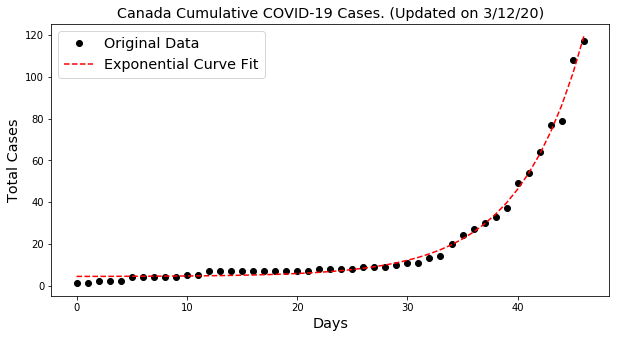



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 103
	Confirmed cases on 3/5/20 	 34
	Ratio: 3.03
	Weekly increase: 202.9 %
	Daily increase: 17.2 % per day
	Doubling Time: 4.4 days

** Based on Logistic Fit**

	R^2: 0.980962849394
	Doubling Time:  7.27 (± 9.55 ) days

** Based on Exponential Fit **

	R^2: 0.980962849973
	Doubling Time:  7.27 (± 3.66 ) days


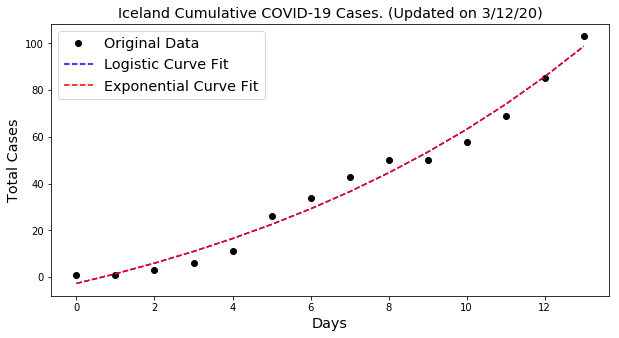

In [91]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are directly calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     3.2                 991.7
1            Italy                     2.3                   4.1
2             Iran                     NaN                   4.6
3     Korea, South                     2.0                  18.9
4           France                     3.0                   2.7
5            Spain                     NaN                   2.2
6          Germany                     3.1                   3.3
7               US                     2.3                   2.4
8           Norway                     1.5                   2.3
9      Cruise Ship                     1.3                   NaN
10     Switzerland                     1.8                   2.8
11 

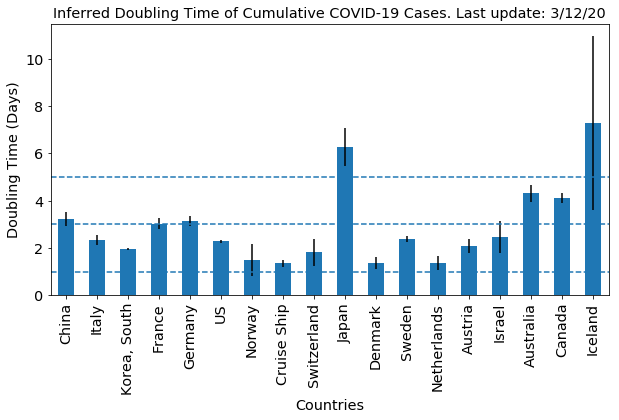

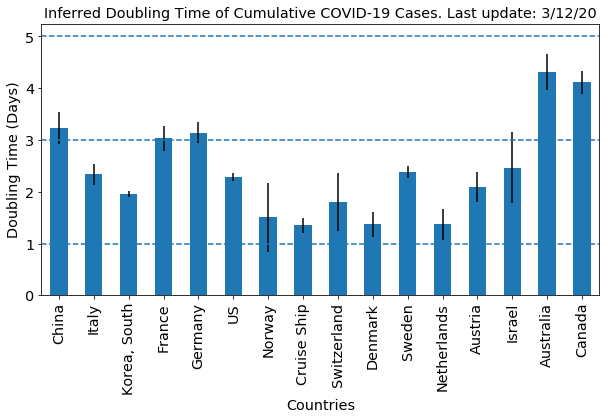

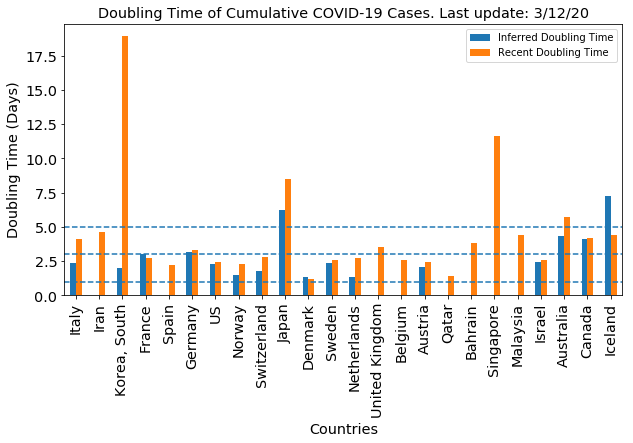

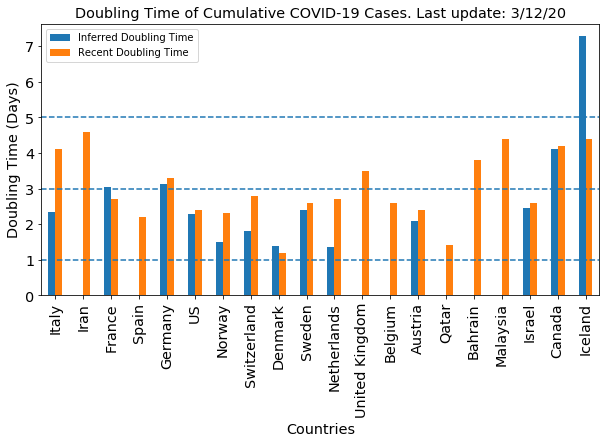

In [93]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are directly calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 30]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 30]
dt.plot.bar(figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 5]
dt.plot.bar(figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [94]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    if ',' in location:
        result = [x.strip() for x in location.split(',')]
        statename = states[result[1]]
        row['State'] = statename
        uscases.loc[index, 'Province/State'] = statename

usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/12/20


,3/12/20
Province/State,
Washington,442
New York,328
California,221
Massachusetts,108
Diamond Princess,46
Colorado,45
Florida,35
Illinois,32
Georgia,31


## Curve Fitting US COVID-19 Cases

                3/12/20
Province/State         
Washington          442
New York            328
California          221
Massachusetts       108


US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 442
	Confirmed cases on 3/5/20 	 70
	Ratio: 6.31
	Weekly increase: 531.4 %
	Daily increase: 30.1 % per day
	Doubling Time: 2.6 days

** Based on Exponential Fit **

	R^2: 0.985808827139
	Doubling Time:  2.19 (± 0.15 ) days


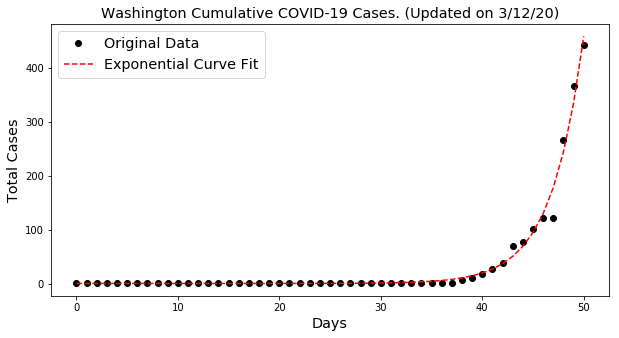



US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 328
	Confirmed cases on 3/5/20 	 23
	Ratio: 14.26
	Weekly increase: 1326.1 %
	Daily increase: 46.2 % per day
	Doubling Time: 1.8 days

** Based on Logistic Fit**

	R^2: 0.990379331336
	Doubling Time:  2.73 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.990379331797
	Doubling Time:  2.73 (± 0.63 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in sqrt


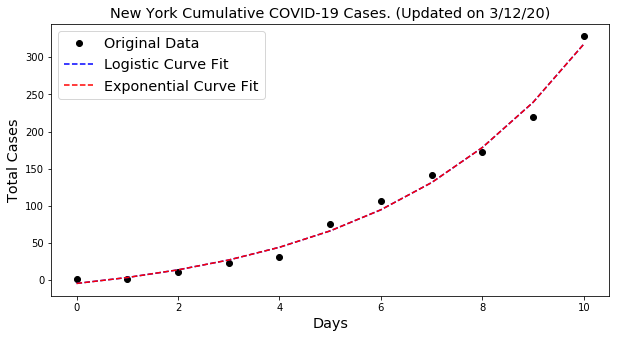



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 221
	Confirmed cases on 3/5/20 	 51
	Ratio: 4.33
	Weekly increase: 333.3 %
	Daily increase: 23.3 % per day
	Doubling Time: 3.3 days

** Based on Exponential Fit **

	R^2: 0.994140211902
	Doubling Time:  2.91 (± 0.14 ) days


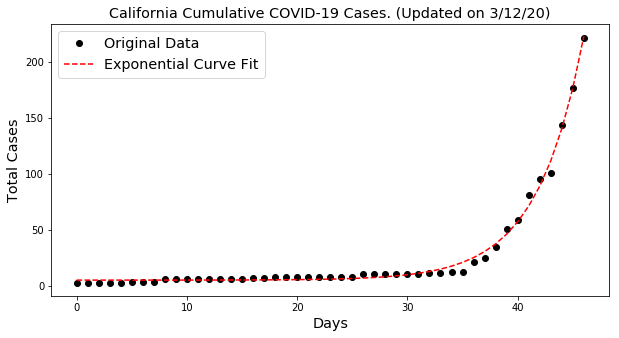



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/12/20 	 108
	Confirmed cases on 3/5/20 	 2
	Ratio: 54.0
	Weekly increase: 5300.0 %
	Daily increase: 76.8 % per day
	Doubling Time: 1.2 days


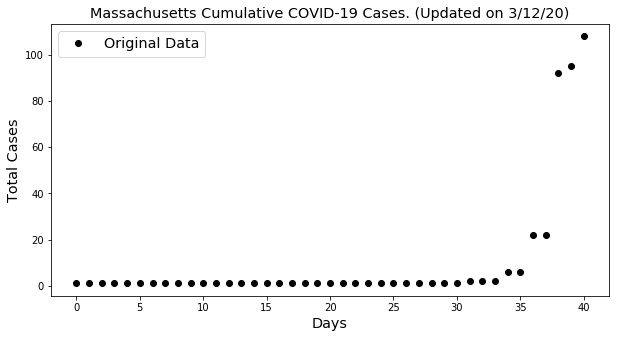

In [95]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are directly calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


          States  Inferred Doubling Time  Recent Doubling Time
0     Washington                     2.2                   2.6
1       New York                     2.7                   1.8
2     California                     2.9                   3.3
3  Massachusetts                     NaN                   1.2




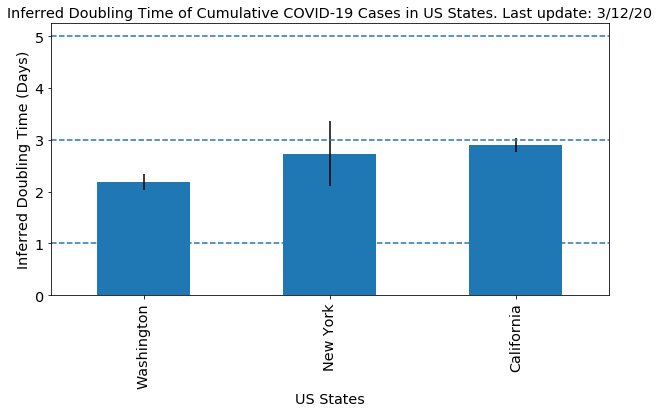

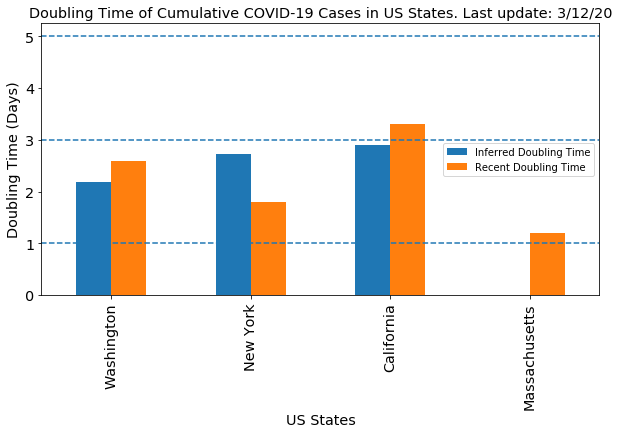

In [97]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are directly calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 30]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()


print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 30]
dt.plot.bar(figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()